# Generating data

This notebook contains a step-by-step walkthrough for data generation. Data are generated using a custom module, [`wiscs`](https://github.com/w-decker/wiscs). This module takes in a set of parameters in the form of a python dictionary.

## Recommendations
1. It is necessary that you install `wiscs`. The first cell under [Imports](#imports) installs the module via `pip`.
2. Read the comments in each cell carefully. There are instructions for what code may require modification. 

## Plots
Plots showing the data are located at the [end](#visualizing-the-data) of this notebook.

## Imports

In [3]:
# If you have not installed `wiscs` locally, run this cell
!pip install git+https://github.com/w-decker/wiscs.git --quiet # REQUIRED FOR THIS NOTEBOOK

In [2]:
# always run this cell, no matter which method you choose
import wiscs
from wiscs.simulate import DataGenerator
from wiscs.utils import make_tasks
import numpy as np

## Generate your own data by modifying the parameters dictionary

### The `params` dictionary

`params` is a dictionary broken up into five basic components. The first three are related to our hypothetical models of conceptual processing: perceptual, conceptual and task. These are each split by modality. Additionally, you must provide parameters related to variance that will be injected at various levels of the experiment. Finally you must provide basic experimental design choices, like the number of subjects, etc. `<modality>.task` takes in an array of number that is the same length as the number of questions. `make_tasks()` permuates an array of linearly spaced numbers to quickly generate some values for you.

### Setting variance 
All parameters related to variance are prepended with the prefix `"sd"`. Only two are required: `"sd.subject"` and `"sd.error"`. All others are optional. With the exception of `"sd.error"` (and a special case for `"sd.subject"` which will be addressed momentarily), when given a value, a random intercept is generated for that variable. Otherwise, a value of `None` means that no noise is added on behalf of that particular factor. If you give `"sd.subject"` a covariance matrix, it will generate a random slope for questions across subjects. When 

In [24]:
# If you wish to generate data based on parameters you wish to define directly in the code, modify + run this cell

########################################################################################
task = make_tasks(low=100, high=200, n=4) # <-- CHANGE THIS AS NEEDED
print(f'Task "times": {task}')
########################################################################################
params = {
    'word.perceptual': 100,
    'image.perceptual': 90,

    'word.conceptual': 100,
    'image.conceptual': 130,

    'word.task': task,
    'image.task': task,

    'sd.item': None, # <-- CHANGE THIS AS NEEDED
    'sd.question': None, # <-- CHANGE THIS AS NEEDED
    'sd.subject':30, # <-- CHANGE THIS AS NEEDED | 'sd.subject' can either be a scalar denoting standard deviation _or_ a 2 x 2 variance-covariance matrix. Generating a covariance matrix will simulate date with a random slope for question
    "sd.error": 50, # <-- CHANGE THIS AS NEEDED

    'n.subject': 50, # <-- CHANGE THIS AS NEEDED
    'n.question': 4, # <-- CHANGE THIS AS NEEDED
    'n.item': 6, # <-- CHANGE THIS AS NEEDED
}
########################################################################################
wiscs.set_params(params)

Task "times": [200. 167. 100. 133.]
Params set successfully


In [25]:
# If you are satisfied with the parameters and are ready to generate data, run this cell
DG = DataGenerator()
DG.fit_transform(seed=123)

/opt/homebrew/anaconda3/envs/wiscs-stats/lib/python3.12/site-packages/wiscs/simulate.py:133: UserWarning: Simulating data for MAIN hypothesis.
  warnings.warn("Simulating data for MAIN hypothesis.")


In [26]:
# If you wish to save the data, modify + run this cell

########################################
output_name1 = "simulated_shared.csv" # <-- CHANGE THIS AS NEEDED | For example, "simulated_data.csv"
########################################

DG.to_pandas().to_csv(f'../data/{output_name1}', index=False)

## Visualizing the data
`wiscs` comes with some default plotting options. The `.plot_bargraph()` method from the `Plot()` class is probably the best way to visualize the data: you can clearly discern between the data which has an interaction of question and one that does not. 

In [27]:
from wiscs.plotting import Plot
P = Plot(DG) # <-- CHANGE THIS AS NEEDED | The `Plot()` class takes in the `DataGenerator()` object

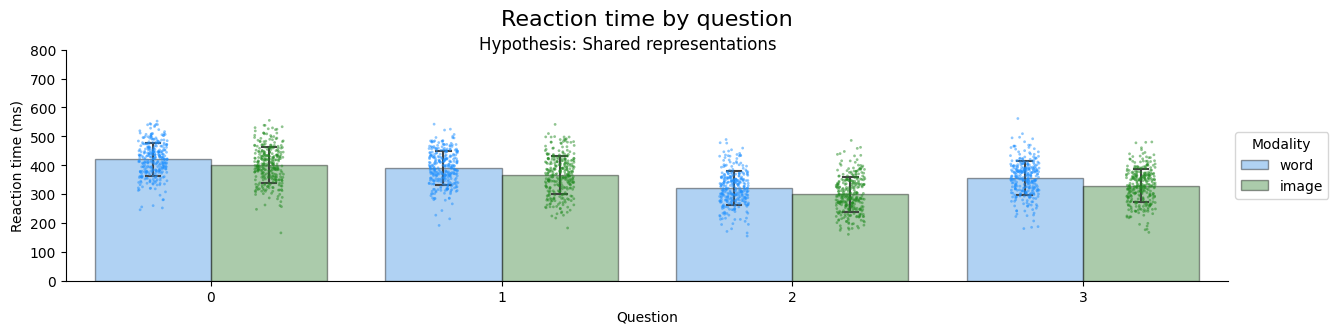

In [28]:
P.plot_bargraph(title="Reaction time by question", hypothesis_title="Hypothesis: Shared representations", show_interaction=False, point_alpah=0.5, point_size=2)

## Testing different values in `params`

`wiscs` makes it easy to update values in the paramters structure without setting them again or running a whole bunch of code. You simply need to provide the key(s) and new value(s) to `DataGenerator().fit_transform({'sd.item':25})` like that. Below is an example with confirmation that the parameter has been updated. 

The ability to dynamically update is critical for power analyses.

In [29]:
print(f'"sd.item" = {DG.params["sd"]["item"]}')

"sd.item" = None


In [30]:
DG.fit_transform(seed=123, params={'sd.item':30}, overwrite=True)
print(f'Updated "sd.item" = {DG.params["sd"]["item"]}')

Updated "sd.item" = 30


/opt/homebrew/anaconda3/envs/wiscs-stats/lib/python3.12/site-packages/wiscs/simulate.py:133: UserWarning: Simulating data for MAIN hypothesis.
  warnings.warn("Simulating data for MAIN hypothesis.")


## The `RInterface()`

I have built a small interface between Python and R. There are two options to choose from: using [`rpy2`](https://rpy2.github.io/) or running a script in the background using `Rscript`. Below is an example of the latter option. `RInterface().script()` works by simply generating a `.temp.R` file and runs the code in the terminal and deletes the file upon completion. This is a little clunky but it avoids the complexities of `rpy2`. However, it doesn't allow one to have quick access to the output of the R code. There are some ways around this, which will be detailed in the power analysis notebook, as it will be relevant there.

In [31]:
from src.r import RInterface
R = RInterface().script

In [33]:
code = """
# imports
suppressMessages(library(lme4))
suppressMessages(library(psych))
suppressMessages(library(dplyr))
suppressMessages(library(lmerTest))

# load data
df <- as.data.frame(read.csv("../data/simulated_shared.csv"))

# model
shared <- lmer(rt ~ modality + question + (1|subject) , data = df, REML = FALSE) # nolint
separate <- lmer(rt ~ modality * question + (1|subject), data = df, REML = FALSE) # nolint

# output
summary(shared)
summary(separate)

# compare
aicvalues <- c("Shared" = AIC(shared), "Separate" = AIC(separate))
names(aicvalues)[which.min(aicvalues)]

# compare
anova(shared, separate)
"""
R(code)


Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: rt ~ modality + question + (1 | subject)
   Data: df

     AIC      BIC   logLik deviance df.resid 
 26082.4  26111.3 -13036.2  26072.4     2395 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.0633 -0.6888  0.0482  0.6959  3.2390 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 1188     34.46   
 Residual             2871     53.58   
Number of obs: 2400, groups:  subject, 50

Fixed effects:
              Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   389.8885     5.3199   64.2990   73.29   <2e-16 ***
modalityword   22.7599     2.1874 2350.0000   10.40   <2e-16 ***
question      -27.3920     0.9782 2350.0000  -28.00   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) mdltyw
modalitywrd -0.206       
question    -0.276  0.000
Linear mix